In [1]:
from tqdm import tqdm
import numpy as np

from seaborn import despine
import seaborn as sns
sns.set_style("ticks")
sns.set_context("talk")

from IPython.display import Image

import matplotlib.pyplot as plt
%matplotlib inline

# Data that is not linearly separable

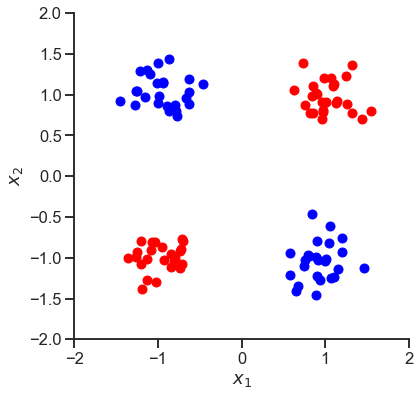

In [2]:
np.random.seed(4128)

n_samples = 50

X1 = []
X2 = []
for sample in range(n_samples):
    # class 1
    if np.random.uniform(0,1,1) > 0.5:
        X1.append(np.array([np.random.normal(-1,0.2,1), np.random.normal(1,0.2,1)]).reshape(1,-1))
    else:
        X1.append(np.array([np.random.normal(1,0.2,1), np.random.normal(-1,0.2,1)]).reshape(1,-1))
    # class 2  
    if np.random.uniform(0,1,1) > 0.5:
        X2.append(np.array([np.random.normal(-1,0.2,1), np.random.normal(-1,0.2,1)]).reshape(1,-1))
    else:
        X2.append(np.array([np.random.normal(1,0.2,1), np.random.normal(1,0.2,1)]).reshape(1,-1))

X = np.concatenate([np.concatenate(X1), np.concatenate(X2)])
y = np.zeros((X.shape[0],1))
y[n_samples:] = 1
y = y.astype(np.int)

# plot the training data
fig, ax = plt.subplots(figsize=(6,6))
for i in range(y.shape[0]):
    if y[i] == 0:
        marker = 'bo'
    else:
        marker = 'ro'
    ax.plot(X[i][0], X[i][1], marker)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
despine(ax=ax)

# XOR with multiple perceptrons

In [3]:
class Perceptron:
    
    def __init__(self, n_in, seed=1, b=None):
        self.w = np.random.uniform(-1,1,n_in)
        if b is None:
            np.random.seed(seed)
            self.b = np.random.uniform(-1,1,1)
            self.fit_b = True
        else:
            self.b = b
            self.fit_b = False
        
    def sigmoid(self, x):
        return 1.0/(1.0 + np.exp(-x))
        
    def predict(self, x):
        self.Z = np.dot(x, self.w) + self.b
        self.A = self.sigmoid(self.Z)
        return self.A
    
    def loss(self, x, y, zerotol=1e-10):
        # derivative of cross entropy loss:
        loss = -y * np.log(self.predict(x) + zerotol) - (1 - y) * np.log(1 - self.predict(x) + zerotol)
        return loss
    
    def derivative_loss(self, x, y):
        # cross entropy derivative wrt Z (dL / dZ):
        return self.predict(x) - y
    
    def update_weights(self, x, y, learning_rate):
        # dL / dZ
        dZ = self.derivative_loss(x, y)
        # Subtract average derivative from weights
        self.w -= learning_rate * 1.0/dZ.shape[0] * np.dot(dZ, x)
        # .. and bias
        if self.fit_b:
            self.b -= learning_rate * 1.0/dZ.shape[0] * np.sum(dZ)
            
    def train(self, x, y, n_steps=10000, batch_size=16, learning_rate=1, verbose=False):
        self.training_loss = np.zeros(n_steps)
        iterator = range(n_steps)
        for step in (tqdm(iterator) if verbose else iterator):
            batch_idx = np.random.choice(X.shape[0], batch_size, replace=False)
            self.training_loss[step] = np.mean(self.loss(X[batch_idx], y[batch_idx]))
            self.update_weights(X[batch_idx], y[batch_idx], learning_rate)

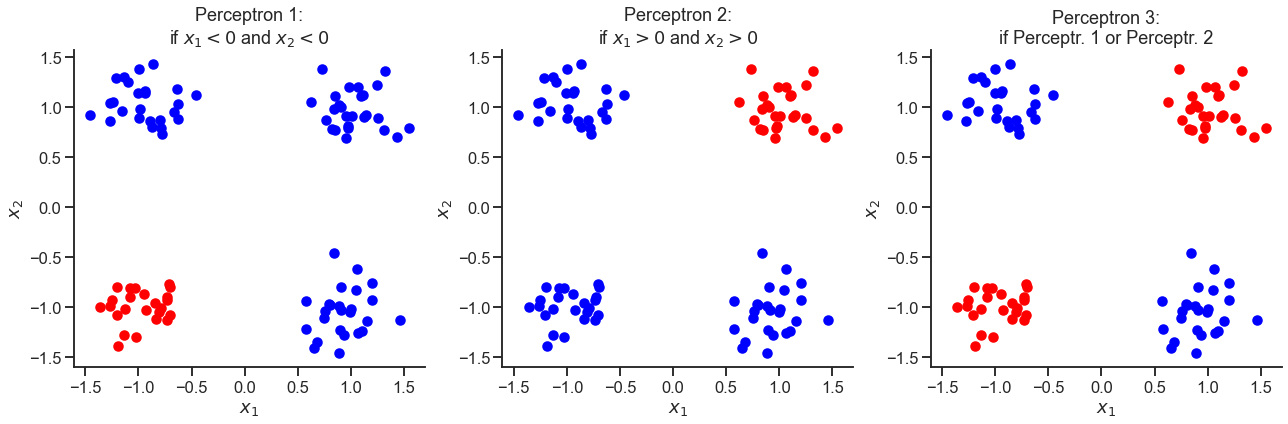

In [4]:
fig, axs = plt.subplots(1,3,figsize=(18,6))
axs[0].set_title('Perceptron 1:\n'+'if '+r'$x_1<0$'+' and '+r'$x_2<0$')
idx1 = np.logical_and(X[:,0]<0, X[:,1]<0)
axs[0].scatter(X[idx1,0], X[idx1,1], color='red')
axs[0].scatter(X[~idx1,0], X[~idx1,1], color='blue')

axs[1].set_title('Perceptron 2:\n'+'if '+r'$x_1>0$'+' and '+r'$x_2>0$')
idx2 = np.logical_and(X[:,0]>0, X[:,1]>0)
axs[1].scatter(X[idx2,0], X[idx2,1], color='red')
axs[1].scatter(X[~idx2,0], X[~idx2,1], color='blue')

axs[2].set_title('Perceptron 3:\n'+'if Perceptr. 1 or Perceptr. 2')
idx3 = np.logical_or(idx1, idx2)
axs[2].scatter(X[idx3,0], X[idx3,1], color='red')
axs[2].scatter(X[~idx3,0], X[~idx3,1], color='blue')

for ax in axs:
    despine(ax=ax)
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
fig.tight_layout()

In [5]:
y1 = idx1.astype(np.int)

np.random.seed(213)
p1 = Perceptron(n_in=2)
p1.train(X, y1)
p1_pred = p1.predict(X)
acc_p1 = np.mean((p1_pred>0.5) == y1)
print(acc_p1)
# standardize
p1_pred = (p1_pred - np.mean(p1_pred, axis=0)) / np.std(p1_pred, axis=0)

1.0


In [6]:
y2 = idx2.astype(np.int)

np.random.seed(4543)
p2 = Perceptron(n_in=2)
p2.train(X, y2)
p2_pred = p2.predict(X)
acc_p2 = np.mean((p2_pred>0.5) == y2)
print(acc_p2)
# standardize
p2_pred = (p2_pred - np.mean(p2_pred, axis=0)) / np.std(p2_pred, axis=0)

1.0


In [7]:
X3 = np.concatenate([p1_pred.reshape(-1,1), p2_pred.reshape(-1,1)], axis=1)
y3 = np.logical_or(y1==1, y2==1).astype(np.int)

np.random.seed(4719)
p3 = Perceptron(n_in=2)
p3.train(X3, y3)
p3_pred = p3.predict(X3)
acc_p3 = np.mean((p3_pred>0.5) == y3)
print(acc_p3)

1.0


In [8]:
xx, yy = np.meshgrid(np.arange(-2, 2, 0.1), np.arange(-2, 2, 0.1))
# predict with percetron 1 & 2
xx1 = p1.predict(np.c_[xx.ravel(), yy.ravel()])
xx2 = p2.predict(np.c_[xx.ravel(), yy.ravel()])
# standardize
xx1 = (xx1 - np.mean(xx1, axis=0)) / np.std(xx1, axis=0)
xx2 = (xx2 - np.mean(xx2, axis=0)) / np.std(xx2, axis=0)
# predict with perceptron 3
zz = p3.predict(np.c_[xx1, xx2])
zz = zz.reshape(xx.shape) # reshape to match xx & yy for plotting

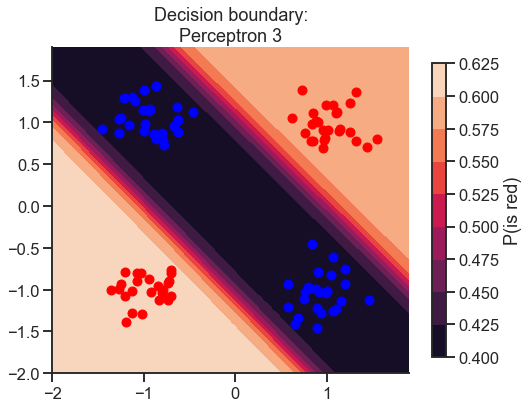

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
cs = ax.contourf(xx,yy,zz)
cbar = fig.colorbar(cs, ax=ax, shrink=0.9)
cbar.set_label('P(is red)')
for i in range(y.shape[0]):
    if y[i] == 0:
        marker = 'bo'
    else:
        marker = 'ro'
    ax.plot(X[i][0], X[i][1], marker)
ax.set_title('Decision boundary:\nPerceptron 3')
despine(ax=ax)

# A neural network (ie. multi-layer perceptron)

# explain concept

# explain back-propagation

In [10]:
class sigmoid():
    def __init__(self):
        self.name = 'sigmoid'
        
    def forward(self, x):
        return 1./(1.+np.exp(-x))
    
    def derivative(self, a):
        return a*(1-a)
    
class softmax():
    def __init__(self):
        self.name = 'softmax'
        
    def forward(self, x):
        e_x = np.exp(x)
        return e_x / e_x.sum(axis=1, keepdims=True)
    
    def derivative(self, a):
        SM = a.reshape((-1,1))
        return (np.diagflat(a) - np.dot(SM, SM.T)).sum(axis=1)

class relu():
    def __init__(self):
        self.name = 'relu'
        
    def forward(self, x):
        return np.maximum(x, 0)
    
    def derivative(self, a):
        d = np.zeros_like(a)
        d[a<=0] = 0
        d[a>0] = 1
        return d
    
class tanh():
    def __init__(self):
        self.name = 'tanh'
        
    def forward(self, x):
        return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    
    def derivative(self, a):
        return 1-a**2

In [11]:
class NeuralNetwork:
            
    def __init__(self, n_in, n_out, n_hidden=[10], activations=None, seed=123):
        
        # init
        self.n_in = n_in
        self.n_out = n_out
        self.n_hidden = np.append(np.array(n_hidden), n_out).astype(np.int) # add output layer
        self.n_layers = self.n_hidden.size
        self.training_loss = []
        self.seed = seed
        self.parms = {}
            
        # initialize weights & biases
        np.random.seed(self.seed)
        n_in = int(self.n_in)
        for layer, n_out in enumerate(self.n_hidden):
            self.parms["W{}".format(layer)] = self._initialize_weight([n_in, n_out])
            self.parms["b{}".format(layer)] = self._initialize_weight([1, n_out])
            # also storage for neuron activations
            self.parms["A{}".format(layer)] = np.zeros((n_in, n_out)) 
            n_in = int(n_out)
        
        # set layer activations
        if activations is None:
            # if no activations are given, use sigmoid
            self.activations = [sigmoid()] * self.n_layers
        else:
            if len(activations) != self.n_layers:
                raise ValueError('/!\ Number of activations does not match number of layers.')
            self.activations = [a() for a in activations]
                       
    def _initialize_weight(self, size, bound=1):
        return np.random.uniform(-1, 1, size=size)
    
    def forward(self, X):
        self.parms['X'] = X
        for layer in range(self.n_layers):
            Z = X.dot(self.parms['W{}'.format(layer)]) + self.parms['b{}'.format(layer)]
            A = self.activations[layer].forward(Z)
            X = A
            self.parms["A{}".format(layer)] = A
        self.y_pred = A
        return A
        
    def predict(self, x):
        y_pred = self.forward(x)
        return np.argmax(y_pred, axis=1)
    
    def loss(self, x, y, zerotol=1e-10):
        """cross entropy loss"""
        if self.activations[-1].name not in ['sigmoid', 'softmax']:
            raise ValueError('loss function only valid for sigmoid or softmax output activations.')
        y_pred = self.forward(x)
        loss = -y * np.log(y_pred + zerotol) 
        loss -= (1 - y) * np.log(1 - y_pred + zerotol)
        return 1.0/x.shape[0] * np.sum(np.sum(loss, axis=1), axis=0) # average over samples
    
    def derivative_loss(self, x, y):
        """derivative of cross entropy loss"""
        if self.activations[-1].name not in ['sigmoid', 'softmax']:
            raise ValueError('derivative of loss only valid for sigmoid / softmax output activations.')
        y_pred = self.forward(x)
        return y_pred - y
        
    def backward(self, x, y, lam=1):
        y_pred = self.forward(x)
        self.training_loss.append(self.loss(x, y))
        dZ = self.derivative_loss(x, y)
        for layer in range(1, self.n_layers)[::-1]: # iterate hidden layers backward
            dW = 1.0/dZ.shape[0] * self.parms["A{}".format(layer-1)].T.dot(dZ)
            db = 1.0/dZ.shape[0] * np.sum(dZ, axis=0, keepdims=True)
            self.parms["W{}".format(layer)] -= self.lr * dW
            self.parms["b{}".format(layer)] -= self.lr * db
            dA = dZ.dot(self.parms["W{}".format(layer)].T)
            dZ = dA * self.activations[layer-1].derivative(self.parms["A{}".format(layer-1)])
        # input layer
        dW = 1.0/dZ.shape[0] * self.parms["X"].T.dot(dZ)
        db = 1.0/dZ.shape[0] * np.sum(dZ, axis=0, keepdims=True)
        self.parms["W0"] -= self.lr * dW
        self.parms["b0"] -= self.lr * db
            
    def fit(self, X, y, lr=0.1, n_steps=10000, batch_size=32, momentum=0.9, verbose=False):
        if verbose:
            print('Beginning training for {} batches ({} samples/batch):'.format(n_steps, batch_size))
        self.lr = lr
        self.momentum = momentum
        iterator = range(n_steps)
        for step in (tqdm(iterator) if verbose else iterator):
            batch_i = np.random.choice(X.shape[0], batch_size, replace=False)
            self.forward(X[batch_i])
            self.backward(X[batch_i], y[batch_i])

In [12]:
np.random.seed(2130)
nn = NeuralNetwork(n_in=2, n_out=1, n_hidden=[3])
nn.fit(X, y, verbose=True, lr=1)

  7%|▋         | 714/10000 [00:00<00:01, 7134.44it/s]

Beginning training for 10000 batches (32 samples/batch):


100%|██████████| 10000/10000 [00:01<00:00, 7231.43it/s]


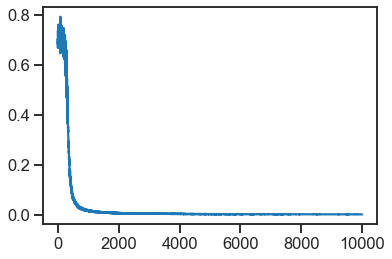

In [13]:
plt.plot(nn.training_loss)

# Decision boundary

In [14]:
xx, yy = np.meshgrid(np.arange(-2, 2, 0.05), np.arange(-2, 2, 0.1))
zz = nn.forward(np.c_[xx.ravel(), yy.ravel()])
# subset to prob for class 1
zz = zz.reshape(xx.shape)

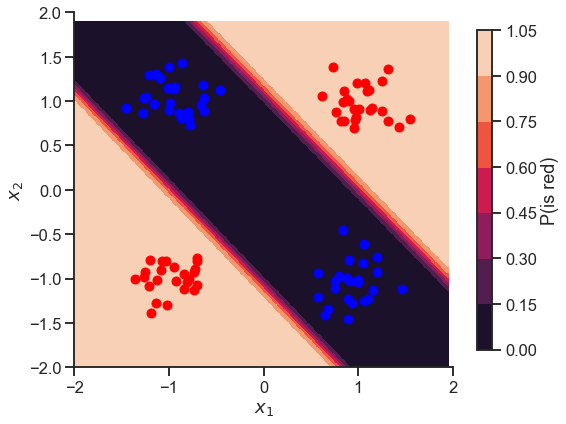

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
cs = ax.contourf(xx,yy,zz)
cbar = fig.colorbar(cs, ax=ax, shrink=0.9)
cbar.set_label('P(is red)')
for i in range(y.shape[0]):
    if y[i] == 0:
        marker = 'bo'
    else:
        marker = 'ro'
    ax.plot(X[i][0], X[i][1], marker)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
despine(ax=ax)
# save figure
fig.tight_layout()
# fig.savefig('figures/Figure-0-5_Perceptron-Decision-Function.png', dpi=600)

# different activation functions for the hidden layer

In [16]:
# this time we will use one output neuron for each of the two classes
# we therefore set n_out = 2 in our specification of the neural network

# by doing so, we also need to change the encoding of our target (y),
# so that it has one value for each of the two output neurons
# this type of encoding is called one-hot encoding and looks like this:
# if class 1: [1, 0], if class 2: [0, 1]; thereby y.argmax(axis=1) will result in our original y

# we will also use a softmax output function, as the two classes
# are mutually exclusive

y_onehot = np.zeros((y.size, 2))
y_onehot[np.arange(y.size), y.ravel()] = 1
print('This is how one-hot encoding looks like for the two classes:')
print(y_onehot[n_samples-1:n_samples+1])
print('\nDimension: {}x{}'.format(*y_onehot.shape))

This is how one-hot encoding looks like for the two classes:
[[1. 0.]
 [0. 1.]]

Dimension: 100x2


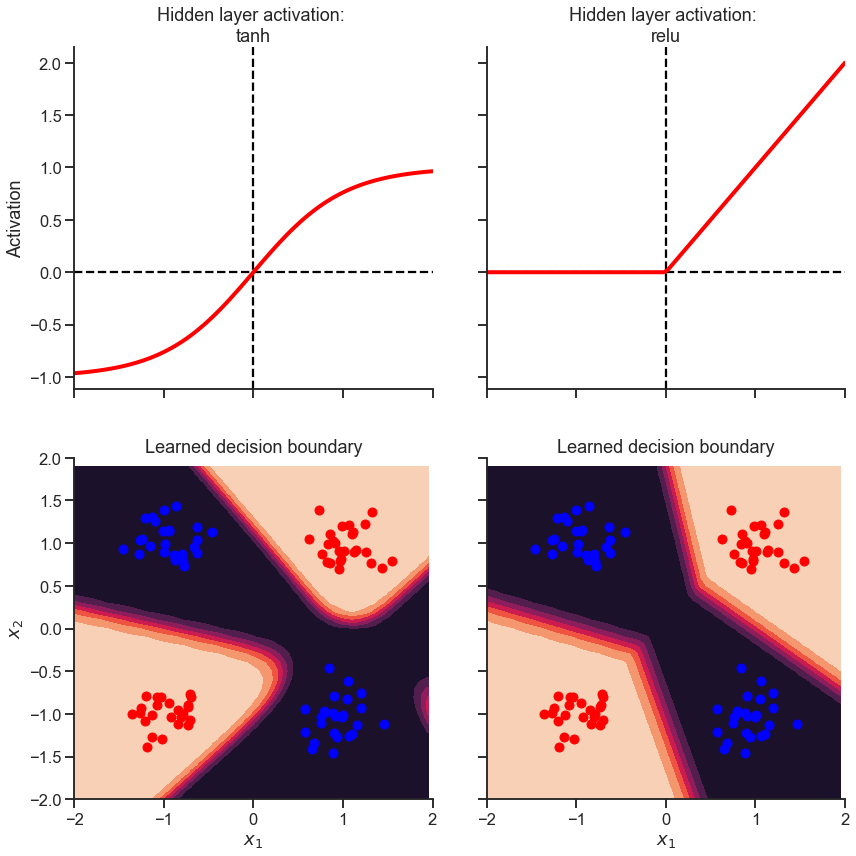

In [17]:
seed = 159
np.random.seed(seed)

fig, axs = plt.subplots(2,2,figsize=(12,12), sharey='row', sharex=True)
for i, act in enumerate([tanh, relu]):
    
    # plot activation function of hidden layer
    ax = axs[0,i]
    x = np.linspace(-2,2,100)
    ax.axhline(0, color='k', ls='--')
    ax.axvline(0, color='k', ls='--')
    ax.plot(x, act().forward(x), color='red', lw=4)
    ax.set_title('Hidden layer activation: \n{}'.format(act().name))
    despine(ax=ax)
    
    # make and fit neural network
    nn = NeuralNetwork(n_in=2, n_out=2, n_hidden=[3], activations=[act, softmax], seed=seed)
    nn.fit(X, y_onehot, verbose=False)
    
    # perdict probabilities
    zz = nn.forward(np.c_[xx.ravel(), yy.ravel()])
    zz = zz[:,1].reshape(xx.shape)
    
    # plot decision boundary
    ax = axs[1,i]
    cs = ax.contourf(xx,yy,zz)
    # cbar = fig.colorbar(cs, ax=ax, shrink=0.9, orientation="horizontal",)
    # cbar.set_label('P(is red)')
    for i in range(y.shape[0]):
        if y[i] == 0:
            marker = 'bo'
        else:
            marker = 'ro'
        ax.plot(X[i][0], X[i][1], marker)
    ax.set_title('Learned decision boundary')
    ax.set_xlabel(r'$x_1$')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    despine(ax=ax)

# some final plotting settings
# cbar = fig.colorbar(cs, shrink=0.9, orientation="horizontal",)
# cbar.set_label('P(is red)')
axs[0,0].set_ylabel('Activation')
axs[1,0].set_ylabel(r'$x_2$')
fig.tight_layout(h_pad=4, w_pad=4)